##### Impor "Library"

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

##### Memuat data "train" dan data "validation"

In [8]:
train_dir = 'D:/Peroyek/backend flask scabies/datasets/train'
validation_dir = 'D:/Peroyek/backend flask scabies/datasets/validation'

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 160 files belonging to 2 classes.


Found 40 files belonging to 2 classes.


In [10]:
# memindah 20% dari data validasi ke data uji
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

##### Augmentasi dan prapemrosesan data

In [11]:
data_augmentation = tf.keras.Sequential([
  # Lapisan prapemrosesan yang membalik gambar secara acak selama pelatihan
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # Lapisan prapemrosesan yang memutar gambar secara acak selama pelatihan.
  tf.keras.layers.RandomRotation(0.2),
])

In [12]:
# membuat metode prapemrosesan yang disertakan dengan model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##### Membuat model dasar

In [13]:
# Membuat model dasar dari model terlatih MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(32, 5, 5, 1280)


##### Membekukan model dasar

mencegah bobot pada lapisan tertentu diperbarui selama pelatihan

In [14]:
base_model.trainable = False

##### Arsitektur model pengaturan

Pemetaan input ke output dalam skenario ini:
- input
- data augmentation layer
- preprocess layer
- MobileV2Net
- GlobalAveragePooling2D layer
- Dropout layer
- Dense layer

Untuk menghasilkan prediksi dari blok fitur, ratakan pada lokasi spasial 5x5, menggunakan lapisan tf.keras.layers.GlobalAveragePooling2D untuk mengonversi fitur menjadi vektor 1280 elemen tunggal per gambar. Ini seperti GlobalAveragePooling2D yang menerapkan pengumpulan rata-rata pada dimensi spasial hingga setiap dimensi spasial menjadi satu.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# (32, 5, 5, 1280) -> (32, 1280)
print(feature_batch_average.shape)

(32, 1280)


Menerapkan lapisan tf.keras.layers.Dense untuk mengubah fitur ini menjadi satu prediksi per gambar.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
# Menyusun layer model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

##### Compile model

menentukan optimizer dan loss function

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

##### Train model

menyimpan histori progres pelatihan model untuk melanjutkan pelatihan lain jika diperlukan

In [19]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5030 - loss: 0.9803 - val_accuracy: 0.2500 - val_loss: 1.0833
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - accuracy: 0.4725 - loss: 0.9352 - val_accuracy: 0.2750 - val_loss: 1.0465
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.4690 - loss: 0.8870 - val_accuracy: 0.2750 - val_loss: 1.0111
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 796ms/step - accuracy: 0.5140 - loss: 0.8642 - val_accuracy: 0.3500 - val_loss: 0.9779
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 781ms/step - accuracy: 0.4335 - loss: 0.8973 - val_accuracy: 0.4250 - val_loss: 0.9465
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5036 - loss: 0.8321 - val_accuracy: 0.4500 - val_loss: 0.9167
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 779ms/step - accuracy: 0.5395 - loss: 0.7963 - val_accuracy: 0.4750 - val_loss: 0.8875
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step - accuracy: 0.4990 - loss: 0.7701 - val_accuracy: 0.4750 - val_loss: 0.86

visualisasi kurva akurasi dan 'loss' pelatihan model

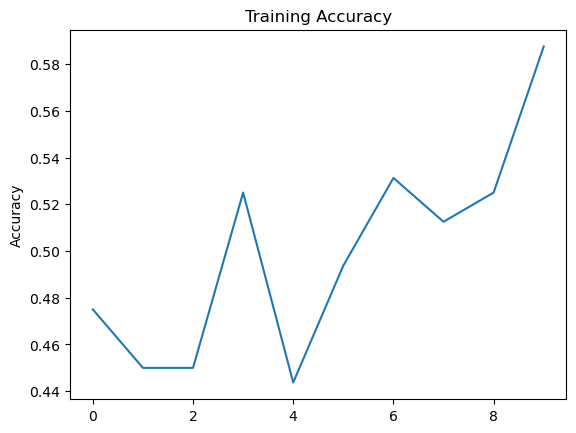

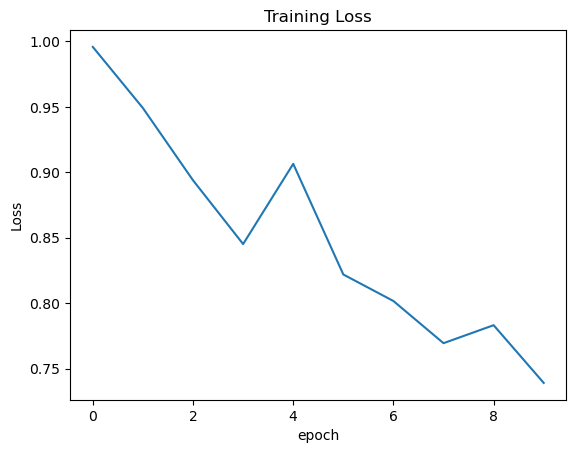

In [20]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

#### Fine Tuning

Buka bekuan lapisan atas model

In [21]:
# menetapkan base model dapat dilatih
base_model.trainable = True
# mengatur semua lapisan sebelum lapisan ke 100 tidak dapat dilatih
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

##### Compile model

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
from keras_tuner import HyperParameters
#hp = HyperParameters()
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #optimizer = Adam(hp.Choice('learning_rate', values=[1e-5, 1e-6])),
              #metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------- ----------- 92.2/129.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.9 MB/s eta 0:00:00


##### Train model

In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4564 - loss: 0.8301 - val_accuracy: 0.5250 - val_loss: 0.7523
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step - accuracy: 0.6155 - loss: 0.6534 - val_accuracy: 0.5250 - val_loss: 0.7535
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.6439 - loss: 0.6111 - val_accuracy: 0.5500 - val_loss: 0.7884
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 789ms/step - accuracy: 0.7204 - loss: 0.4973 - val_accuracy: 0.5500 - val_loss: 0.8230
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 823ms/step - accuracy: 0.7646 - loss: 0.4071 - val_accuracy: 0.5500 - val_loss: 0.8552
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step - accuracy: 0.8005 - loss: 0.4631 - val_accuracy: 0.5250 - val_loss: 0.8931
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 806ms/step - accuracy: 0.8057 - loss: 0.4150 - val_accuracy: 0.5250 - val_loss: 0.9405
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 851ms/step - accuracy: 0.7987 - loss: 0.4297 - val_accuracy: 0.5000 - val

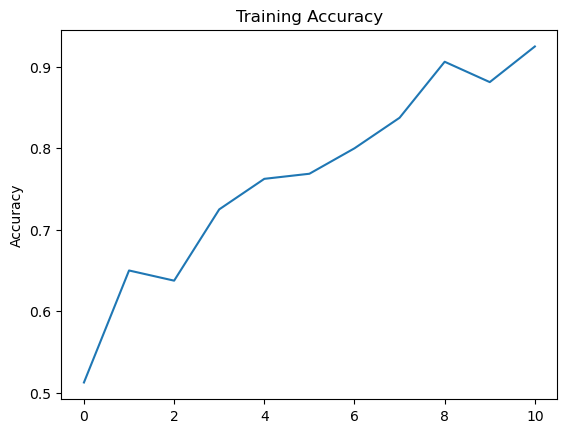

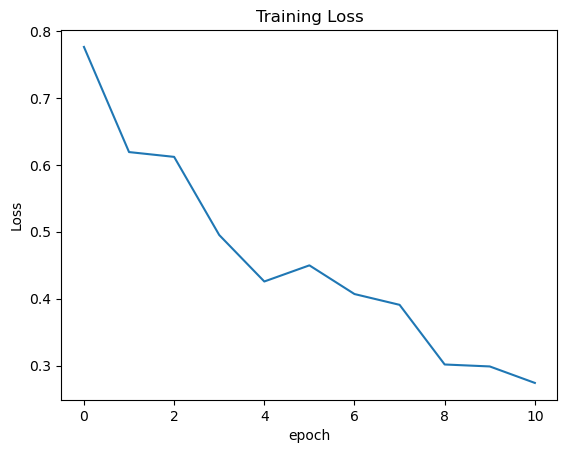

In [24]:
acc = history_fine.history['accuracy']
loss = history_fine.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

##### Prediksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


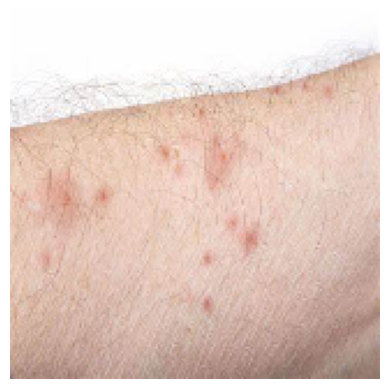

Probabilities: [[0.02840905]]
Prediction: NON_SCABIES


In [29]:
#create new file test.py and run this file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from scipy.special import expit

uploaded = 'D:/Peroyek/backend flask scabies/images/OIP (2).jpeg'

class_names = ['NON_SCABIES', 'SCABIES']

img = image.load_img(uploaded, target_size=(160, 160))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
preds = model.predict(x)
probs = expit(preds)
pred = (probs >= 0.07).astype(int)

# Display the image and prediction
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"Probabilities: {probs}")
print(f"Prediction: {class_names[pred[0][0]]}")

In [21]:
from scipy.special import expit  # Sigmoid function

# Mengonversi logit ke probabilitas
probs = expit(preds)
print(probs)

[[0.40892336]]


##### Menyimpan model yang telah dibuat

In [23]:
history_fine.history.keys()
model.save("model_scabies.h5")

TypeError: cannot pickle 'module' object

##### Menguji model menggunakan Flask

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

import tensorflow as tf
import numpy as np

app = Flask(__name__)

model = load_model("model_scabies.h5")

labels = ["NON_SCABIES", "SCABIES"]

@app.route("/")
def main():
    return "You have reached main page !"

@app.route('/predict-first', methods=['POST'])
def prediction():
    if 'image' not in request.files:
        return 'No image uploaded', 400

    file = request.files['image']

    # Load gambar menggunakan PIL
    gambar = Image.open(file)
    gambar = gambar.convert("RGB")
    # Resize gambar jika diperlukan
    ukuran_baru = (160, 160)  # ukuran yang diinginkan
    gambar = gambar.resize(ukuran_baru)

    # Konversi gambar ke array numpy
    gambar_array = np.array(gambar)

    # Tambahkan dimensi batch
    gambar_array = np.expand_dims(gambar_array, axis=0)

    # Preprocess gambar untuk MobileNetV2
    gambar_array = preprocess_input(gambar_array)

    # Lakukan prediksi menggunakan model machine learning
    predictions = model.predict_on_batch(gambar_array).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.079, 0, 1)

    predicted_label = labels[predictions[0].numpy()]

    return jsonify({'predicted_label': predicted_label})

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return 'No image uploaded', 400

    file = request.files['image']

    gambar = Image.open(file)

    ukuran_baru = (160, 160)
    gambar = gambar.resize(ukuran_baru)

    gambar_array = np.array(gambar)

    gambar_array = np.expand_dims(gambar_array, axis=0)

    predictions = model.predict(gambar_array)

    if predictions > 0:
        predicted_label = 'SCABIES'
    elif predictions == 0:
        predicted_label = 'NON-SCABIES'

    return jsonify({'predicted_label': predicted_label}), 200

In [ ]:
if __name__ == '__main__':
    app.run(port=5000, host='0.0.0.0')